In [1]:
%matplotlib notebook
import os
import sys
import glob
#import tiffcapture as tc #using jpg for now
import numpy as np
import cv2
import numpy.linalg as lin
import math
import itertools
import warnings
import scipy.optimize
import matplotlib.pyplot as plt
import time
import configparser
import argparse
from statistics import mean
from mpl_toolkits.mplot3d import Axes3D


In [2]:
# This code performs the "Belden" method of self-calibration for multiple cameras in a refractive system 

#class definitions
class planeData(object):
    def __init__(self,dX,dY,nX,nY,num_calib_planes,fileType, z0, scaleInfo):
        self.dX = dX
        self.dY = dY
        self.nX = nX
        self.nY = nY
        self.ncalplanes = num_calib_planes
        self.fileType = fileType
        self.z0 = z0
        self.scaleInfo = scaleInfo
        
class sceneData(object):
    def __init__(self,n1,n2,n3,tW,zW):
        self.n = [n1,n2,n3]
        self.tW = tW
        self.zW = zW

class cameraData(object):
    def __init__(self,sX,sY,pix_pitch,so,f,ncams):
        self.sX = sX
        self.sY = sY
        self.shiftx = sX/2
        self.shifty = sY/2
        self.mpix = 1/pix_pitch
        self.f = f
        self.so = so
        self.a0 = 1/pix_pitch*f
        self.ncams = ncams
        
class refracTol(object):
    def __init__(self,tol,fg_tol,maxiter,bi_tol,bi_maxiter,z3_tol,rep_err_tol):
        self.tol = tol
        self.fg_tol = fg_tol
        self.maxiter = maxiter
        self.bi_tol = bi_tol
        self.bi_maxiter = bi_maxiter
        self.z3_tol = z3_tol
        self.rep_err_tol = rep_err_tol 
    
def setupCamera(camData,nparam=7):
    #Generate initial guesses for camera parameters
    #Inputs:
    # ncams      - number of cameras
    # nparam     - number of parameters in model (default is 7, which is what the rest of the functions expect)
    # camData:
    #   a0       - magnification
    #
    #Output:
    # cam_params - nparam x ncams matrix of camera parameters
    
    a0 = camData.a0
    ncams = camData.ncams
    
    cam_params = np.zeros([nparam,ncams])
    cam_params[6]=a0*np.ones([1,ncams])
    
    return cam_params

def setupPlanes(nplanes,z0):
    #Generate initial guesses for plane parameters
    #Inputs:
    # nplanes      - number of planes in calibration images
    # z0           - origin of z axis for each plane
    #
    #Outputs:
    # plane_params - 6xNplanes matrix of plane parameters
    
    plane_params = np.zeros([6,nplanes])
    plane_params[5]=z0
    
    return plane_params
    

In [3]:
def getSpacedFrameInd(tiff, n, nframes = 0) :
    #Generate indices of n evenly spaced frames in a multipage tiff
    #Inputs:
    # tiff       - location of tiff being calibrated
    # n          - number of indices to generate  
    # nframes    - number of frames in each tiff -- if not provided, program will try to determine(slow) 
    #
    #Outputs:
    # frameind   - indices of frames to be used for calibration
    
    # try to get the total number of images in each calibration file -- doesn't always work
    if not nframes:
        nframes  = tc.opentiff(tiff)._count_frames()
        if nframes == 0:
            raise Exception ('Unable to count frames in image ' + tiff)
    
    frameind = np.linspace(0,nframes-1,num=n,endpoint=True,retstep=False)
    frameind = np.uint16(frameind)
    
    return frameind
    
def parseConfigFile(configPath):
    #read calibration parameters from a configuration file
    #and setup experimental parameter storage objects
    #Input:
    # configPath - string with relative path to configuration file
    #
    #Configuration file inputs:
    # dataPath - 
    # fileType -
    # n1 -
    # n2 -
    # n3 -
    # dX -
    # dY -
    # nX -
    # nY -
    # so -
    # f -
    # tW -
    # sX -
    # sY - 
    # zW -
    # zC -
    # bounded - default on
    #
    #Outputs:
    # planeData -
    # cameraData -
    # sceneData -
    # tolerances -
    # calImgs -
    # bounded -
    ##
    
    # create config parser and read config file
    config = configparser.ConfigParser()
    config.read(configPath)
    pa = config['setup']
    p = config['plane']
    c = config['camera']
    s = config['scene']
    
    # setup experimental parameter storage objects

    #calibration images
    fileType = pa['fileType']
    dataPath = pa['dataPath']
    exptPath = dataPath + '/calibration_results'
    camIDs = getCameraNames(dataPath)
    calImgs, nCalPlanes = getCalibImages(dataPath, exptPath, camIDs, fileType)
    
    #plane data
    dX = p.getint('dX')
    dY = p.getint('dY')
    nX = p.getint('nX')
    nY = p.getint('nY')
    zC = p.getint('zC')
    z0 = zC*np.linspace(0,1,nCalPlanes)
    scaleInfo = [p.getint('centerCamID')-1, p.getint('centerImgIndex')-1]
    pData = planeData(dX,dY,nX,nY,nCalPlanes,fileType, z0, scaleInfo)

    #camera data
    sX = c.getint('sX')
    sY = c.getint('sY')
    pix_pitch = c.getfloat('pix_pitch')
    so = c.getint('so')
    f = c.getint('f')
    nCams = len(camIDs)
    cData  = cameraData(sX,sY,pix_pitch,so,f,nCams)

    #scene data
    n1 = s.getfloat('n1')
    n2 = s.getfloat('n2')
    n3 = s.getfloat('n3')
    tW = s.getfloat('tW')
    zW = s.getfloat('zW')
    sData   = sceneData(n1,n2,n3,tW,zW)

    #tolerances (hardcoded since aren't changed often)
    tol = 1.5e-8   
    fg_tol = 0.001
    maxiter = 500
    bi_tol  = 1e-3
    bi_maxiter = 1000
    z3_tol = 1e-3
    rep_err_tol =.05
    tolerances  = refracTol(tol,fg_tol,maxiter,bi_tol,bi_maxiter,z3_tol,rep_err_tol)

    bounded = pa.getboolean('bounded')

    return [pData, cData, sData, tolerances, calImgs, exptPath, camIDs, bounded]

def getCameraNames(dataPath):
    
    folders = glob.glob(os.path.join(dataPath,'calibration','*'))
    camIDs = []
    for i in range(0,len(folders)):
        camIDs.append(os.path.basename(folders[i]))
    return camIDs

def getCalibImages(datapath, exptpath, camNames, fileType):
    # return correct images for calibration from input file(s)
    #Inputs:
    # datapath   - path to stored images
    # exptpath   - path to output saved data
    # camNames   - names of cameras to which images belong
    # ncalplanes - number of calibration planes in images
    #
    #Outputs:
    # ical       - images to use for calibration (ncams x nplanes)
    
    # find calibration files to use
    ncams = len(camNames)

    if (fileType=='.jpg'):
        ical = []
        ncalplanes = 0
        
        print('Reading JPG images')
        for i in range(0,ncams):
            #create and read images
            imagepath = os.path.join(datapath,'calibration',camNames[i])
            images = [cv2.imread(file, 0) for file in glob.glob(os.path.join(imagepath,'*'+fileType))]
            
            #determines num of planes based on num of images (should be the same across paths)
            if(i ==0): ncalplanes = len(images) 

            ical.append(images)
    else:
        print(fileType + " currently not supported.")

    return [ical, ncalplanes]
            

In [4]:
def findCorners(pData, ncams, path, imgs =[], save_corners = bool(0)):
    #Find chessboard corners on grid images
    #Inputs:
    # ncams             - number of cameras
    # pData:
    #     ncalplanes    - number of planes
    #     nX,nY         - number of grid points per row and column on each plane
    # path              - location to get images from if they aren't being passed in directly
    #                     (in which case they should be stored by camera in a folder called 'calibration')
    # imgs              - array of images in which to find corners (order should be [camera[image]]). 
    #                     If not given, program will look on the path.
    # save_corners      - boolean; whether save a file with the corners
    #
    #Outputs:
    # cor_all           - 2 by nX*nY*ncalplanes by ncams array of corner coordinates
    # saved corners.dat file containing corner coordinates on path if save_corners is true
    
    ncalplanes    = pData.ncalplanes
    nX,nY         = pData.nX, pData.nY
    
    if not any(imgs):
        print('Loading images from path information')
        imgloc = 'path' # images not passed, so they should be found on the path
        cams   = sorted(glob.glob(os.path.join(path,'calibration','*'))) # folder holding image folders must be named 'calibration'
        if len(cams)<ncams:
            if not any (cams):
                raise Exception ("Folder containing calibration image folders not found or empty. It should be named 'calibration' and located in " +path)
            else:    
                raise Exception ("Not enough camera folders in calibration folder.")
    else: 
        print('Using preloaded images')
        imgloc = 'imgs' # images were passed directly        
    
    if save_corners:
        f = open(os.path.join(path,'corners.dat'), 'w')
        f.write(str(ncalplanes)+'\n')
        f.write(str(ncams)+'\n')

    cor_all = np.zeros([2,ncalplanes*nX*nY,ncams])
    
    for i in range(0,ncalplanes):
        for j in range(0,ncams):            
            #get image
            if imgloc == 'path':
                files = sorted(glob.glob(os.path.join(cams[j],'*.tif')))
                if len(files) < ncalplanes:
                    raise Exception ("Less than " +str(ncalplanes) + " images in " + cams[j] + " folder.")
                file = files[i]
                I_gray = cv2.imread(file, 0)
                I = cv2.cvtColor(I_gray,cv2.COLOR_GRAY2RGB)
                print ('Finding corners in '+file)
                
            else:  
                I = imgs[j][i]
                print ('Finding corners in preloaded image '+str(i+1) +' in camera ' +str(j+1))
            
            # Find corners using opencv
            ret, corners = cv2.findChessboardCorners(I,(nX,nY),flags=cv2.CALIB_CB_ADAPTIVE_THRESH | cv2.CALIB_CB_FILTER_QUADS)
            criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 0.01)
            cv2.cornerSubPix(I, corners, (10,10), (-1,-1), criteria)
            
            '''
            #For debugging: Show corners
            Itmp = I.copy()
            for cor in corners:
                radius = (cor[0][0], cor[0][1])
                cv2.circle(Itmp, radius, 5, (255, 0, 0), 2)
            cv2.drawChessboardCorners(Itmp, (nX,nY), corners, ret)
            cv2.imshow('I', Itmp)
            cv2.waitKey(0)
            cv2.destroyAllWindows()
            '''

            # Check number of found corners and organize if all present or detect missing points
            if (ret and len(corners)==nX*nY):
                
                # determining row by row (dir < 0) or column by column (dir > 0)
                dir = corners[1]-corners[2]
                dir = dir[0][0]
                N = len(corners)-1
    
                cor = np.empty(0)
                for k in range(0,nX):
                    for l in range(0,nY):
                        if (dir>0):
                            cor = np.append(cor, corners[N - (k + nX*l)])
                        else:
                            cor = np.append(cor, corners[k + nX*l])

                # corner order is ascending x (right), ascending y (down), by column first
                cor = cor.reshape(nX*nY,2)
                
            else:
                # finding missing points
                print('Missing corners! Check nx and ny values and that checkerboard has white border.')
                
            cor_all[:,i*nX*nY:(i+1)*nX*nY,j] = cor.T

            if save_corners:
                for c in cor:
                    f.write(str(c[0])+'\t'+str(c[1])+'\n')

    print('\nDONE finding corners!')
 
    return cor_all

def planar_grid_to_world(plane_params,xyzgrid,planeData):
    #Calculate world points based on plane parameters
    #Inputs:
    # plane_params - 6 x nplanes matrix of plane parameters
    # xyzgrid      - 3 x nX*nY matrix containing points on a grid
    # planeData:
    #   nplanes    - number of calibration planes 
    #   nX,nY      - number of grid points per row, column on each plane
    #    
    #Output:
    # X            - World Points (3 x nX*nY*nplanes)
    
    nplanes         = planeData.ncalplanes
    nX,nY           = planeData.nX, planeData.nY
    phi,alpha,theta = plane_params[0:3]
    XG              = plane_params[3:6]
    
    for j in range(0,nplanes):
        Rot = np.array([[math.cos(theta[j])*math.cos(phi[j]) + math.sin(theta[j])*math.sin(alpha[j])*math.sin(phi[j]), math.sin(theta[j])*math.cos(alpha[j]), -math.cos(theta[j])*math.sin(phi[j]) + math.sin(theta[j])*math.sin(alpha[j])*math.cos(phi[j])], \
                        [-math.sin(theta[j])*math.cos(phi[j]) + math.cos(theta[j])*math.sin(alpha[j])*math.sin(phi[j]), math.cos(theta[j])*math.cos(alpha[j]), math.sin(theta[j])*math.sin(phi[j]) + math.cos(theta[j])*math.sin(alpha[j])*math.cos(phi[j])], \
                        [math.cos(alpha[j])*math.sin(phi[j]),-math.sin(alpha[j]), math.cos(alpha[j])*math.cos(phi[j])]])

        xtmp = np.reshape(XG[:,j],(3,1))
        XYZgrid=np.dot(lin.inv(Rot),xyzgrid)+np.repeat(xtmp,nX*nY,axis=1)

        if j == 0:
            X = XYZgrid
        else:
            X = np.concatenate((X,XYZgrid),axis=1)
    return X

def ptnormalize(x):
    # Rescale and shift points to improve conditioning
    #
    #Inputs:
    # x     - points to be normalized (world or image)
    #
    #Outputs:
    # xnorm - normalized points
    # T     - matrix for reversing normalization
    
    M = x.shape[2]

    if x.shape[0]==2:

        xnorm = np.empty_like(x)
        T = np.zeros([3,3,x.shape[2]])

        for j in range (0,M):
            xtemp = x[:,:,j]
            xm = -(np.mean(xtemp,axis=1,keepdims=True))
            xs = np.sum(np.square(xtemp+np.repeat(xm,x.shape[1],axis=1)),axis=0)
            d = np.sqrt(xs)
            s = np.sqrt(2)/(np.sum(d)/len(d))

            T[:,:,j] = ([s,0,s*xm[0]], \
                        [0,s,s*xm[1]], \
                        [0,0,1])

            xpad = np.append(xtemp,np.ones((1,x.shape[1])),axis=0)
            xnormtemp = np.dot(T[:,:,j],xpad)
            xnorm[:,:,j]=xnormtemp[0:2,:]

    elif x.shape[0]==3:

        xnorm = np.empty_like(x)
        T = np.zeros([4,4,x.shape[2]])

        for j in range (0,M):
            xtemp = x[:,:,j]
            xm = -(np.mean(xtemp,axis=1,keepdims=True))
            xs = np.sum(np.square(xtemp+np.repeat(xm,x.shape[1],axis=1)),axis=0)
            d = np.sqrt(xs)
            s = np.sqrt(2)/(np.sum(d)/len(d))

            T[:,:,j] = ([s,0,0,s*xm[0]], \
                        [0,s,0,s*xm[1]], \
                        [0,0,s,s*xm[2]], \
                        [0,0,0,1])
            xpad = np.append(xtemp,np.ones((1,x.shape[1])),axis=0)
            xnormtemp = np.dot(T[:,:,j],xpad)
            xnorm[:,:,j]=xnormtemp[0:3,:]

    else:
        print('error normalizing')
        print(x.shape[0])

    return (xnorm,T)

def P_from_DLT(X,u):
    #Camera matrix from direct linear transform
    #Inputs:
    # X - 3D world points
    # u - 2D image points
    #
    #Outputs:
    # P - 3 x 4 x # of cameras camera matrix
    
    if len(X.shape)>2:
        p = X.shape[2]
    else:
        p = 1
    if len(u.shape)>2:
        M = u.shape[2]
    else:
        M=1

    if p < M:
        Xtmp = np.zeros([X.shape[0],X.shape[1],M])
        for j in range (0,M):
            Xtmp[:,:,j]=X
        X = Xtmp

    #Condition points
    u,T=ptnormalize(u)
    X,U=ptnormalize(X)
    
    P = np.zeros([3,4,M])

    for j in range (0,M):
        utmp = u[:,:,j]
        xtmp = X[:,:,j]
        c = utmp.shape[1]
        zv = np.zeros([1,4])

        for k in range (0,c):
            u1 = np.append(utmp[:,k],1)
            X1 = np.append(xtmp[:,k],1)
            Dtmp = np.zeros([2,12])
            Dtmp[0,0:4]=u1[2]*X1
            Dtmp[0,4:8]=zv
            Dtmp[0,8:12]=-u1[0]*X1
            Dtmp[1,0:4]=zv
            Dtmp[1,4:8]=-u1[2]*X1
            Dtmp[1,8:12]=u1[1]*X1
            if k == 0:
                D=Dtmp
            else:
                D=np.concatenate((D,Dtmp),axis=0)
        
        # SVD
        uS,sS,vS = lin.svd(D, full_matrices=False)
        
        p = vS[11,:]
        p = np.reshape(p,[3,4])
        
        # Decondition
        P[:,:,j]=np.dot(np.dot(lin.inv(T[:,:,j]),p),U[:,:,j])
        P[:,:,j]=P[:,:,j]/P[2,3,j]
        
    return P

def cam_decomp(p):
    #Camera center by SVD
    #Inputs:
    # p - camera matrix
    #Outputs:
    # C - coordinates of camera center
    
    u,s,v=lin.svd(p, full_matrices=True)
    C = v[3,:]/v[3,3]
    C = C[0:3]
    return C

def f_eval_1eq(r1,r2,z1,z2,n1,n2):
    #evaluate ray tracing function, gradients for one refractive equation (snell's law with 2 media)
    #Inputs:
    # n1,2     - indices of refraction
    # r1,2     - length of ray in each refractive medium
    # z1,2     - z coordinate of ray intersection with each medium
    #
    #Outputs:
    # f        - output of ray tracing equation for one refractive interface
    # df_dr1   - derivative of f with regards to r1
    
    r1,r2,z1,z2,n1,n2 = np.array([r1,r2,z1,z2,n1,n2])+0. #convert all values to floats

    f      = (r1)/np.sqrt(r1**2 + z1**2) \
             - (n2/n1)*(r2-r1)/np.sqrt((r2-r1)**2 + z2**2)

    df_dr1 = 1/np.sqrt(r1**2 + z1**2) - r1**2/(r1**2 + z1**2)**(3./2) \
             + (n2/n1)/np.sqrt(z2**2 + (r1-r2)**2) \
             - (n2/n1)*(r1-r2)*(2*r1-2*r2)/(2*((r1-r2)**2 + z2**2)**(3./2))

    return (f,df_dr1)

def f_eval_2eq(r1,r2,r3,z1,z2,z3,n1,n2,n3):
    # evaluate ray tracing function, gradients for 2 refractive equations in (snell's law with 3 media) 
    #Inputs:
    # n1,2,3     - indices of refraction
    # r1,2,3     - length of ray in each refractive medium
    # z1,2,3     - z coordinate of ray intersection with each medium
    #
    #Outputs:
    # f          - first ray tracing equation for 2 refractive interfaces
    # g          - second ray tracing equation for 2 refractive interfaces
    # df_dr1     - derivative of f with regards to r1
    # dg_dr1     - derivative of g with regards to r1
    
    [r1,r2,r3,z1,z2,z3,n1,n2,n3]=np.array([r1,r2,r3,z1,z2,z3,n1,n2,n3])+0. #convert all values to floats
    
    f = (r1)/np.sqrt(r1**2. + z1**2.) \
        - (n2/n1)*(r2-r1)/np.sqrt((r2-r1)**2. + z2**2.)

    df_dr1 = 1./np.sqrt(r1**2. + z1**2.) \
             - r1**2./((r1**2. + z1**2.)**(3./2.)) \
             + (n2/n1)/np.sqrt(z2**2. + (r1-r2)**2.) \
             - (n2/n1)*(r1-r2)*(2.*r1-2.*r2)/(2.*((r1-r2)**2. + z2**2.)**(3./2.))

    df_dr2 = (n2/n1)*(r1-r2)*(2.*r1-2.*r2)/(2.*((r1-r2)**2. + z2**2.)**(3./2.)) \
             - (n2/n1)/np.sqrt(z2**2. + (r1-r2)**2.)


    g      = (r2-r1)/np.sqrt((r2-r1)**2. + z2**2.) \
             - (n3/n2)*(r3-r2)/np.sqrt((r3-r2)**2. + z3**2.)

    dg_dr1 = (r1-r2)*(2*r1-2*r2)/(2.*((r1-r2)**2. + z2**2.)**(3./2.)) \
             - 1./np.sqrt(z2**2. + (r1-r2)**2.)

    dg_dr2 = 1./np.sqrt((r1-r2)**2. + z2**2.) \
             + (n3/n2)/np.sqrt(z3**2 + (r2-r3)**2.) \
             - (r1-r2)*(2.*r1-2.*r2)/(2.*((r1-r2)**2. + z2**2.)**(3./2.)) \
             - (n3/n2)*(r2-r3)*(2.*r2-2.*r3)/(2.*((r2-r3)**2. + z3**2.)**(3./2.))

    return (f,df_dr1,df_dr2,g,dg_dr1,dg_dr2)

def NR_1eq(r1,r2,z1,z2,n1,n2,tol):
    #Newton-Raphson Iteration for 1 equation (only 2 refractive media i.e. neglecting tank wall)
    #Inputs:
    # maxIter    - max # of iterations for solver
    # n1,2       - indices of refraction
    # r1,2       - length of ray in each refractive medium
    # z1,2       - z coordinate of ray intersection with each medium
    # tol        - object containing tolerances for solver
    #
    #Outputs:
    # r1new      - length of ray from source to tank wall
    # Iter       - number of iterations for solution
    # max_err_r1 - maximum error in solution
    
    r1new      = r1
    Iter       = 0
    max_err_r1 = 1000

    while max_err_r1 > tol:
        r1_old     = r1new
        f,df_r1    = f_eval_1eq(r1_old,r2,z1,z2,n1,n2) #evaluate snell's law equation
        r1new      = r1_old - f/df_r1
        err_r1     = abs(r1new-r1_old)
        Iter       = Iter + 1
        max_err_r1 = err_r1.max()
        
    return (r1new,Iter,max_err_r1)

def NR_2eq(r1,r2,r3,z1,z2,z3,n1,n2,n3,tol,maxIter):
    #Newton-Raphson iteration to solve the refractive imaging model for 2 equations (3 refractive media - air-tank-wall)
    #Inputs:
    # maxIter    - max # of iterations for solver
    # n1,2,3     - indices of refraction
    # r1,2,3     - length of ray in each refractive medium
    # z1,2,3     - z coordinate of ray intersection with each medium
    # tol        - object containing tolerances for solver
    #
    #Outputs:
    # r1new      - length of ray from source to tank wall
    # r2new      - length of ray in tank wall
    # Iter       - number of iterations for solution
    # max_err_r1 - maximum error in solution for r1
    # max_err_r2 - maximum error in solution for r2
    
    r1new      = r1
    r2new      = r2
    Iter       = 0
    max_err_r1 = 1000
    max_err_r2 = 1000
    
    while (max_err_r1 > tol or max_err_r2 > tol) and Iter < maxIter:
        r1_old = r1new
        r2_old = r2new
        
        #evaluate snell's law equations
        f,df_dr1,df_dr2,g,dg_dr1,dg_dr2 = f_eval_2eq(r1_old,r2_old,r3,z1,z2,z3,n1,n2,n3)

        denom = (df_dr1*dg_dr2 - df_dr2*dg_dr1)
        r1new = r1_old - (f*dg_dr2 - g*df_dr2)/denom
        r2new = r2_old - (g*df_dr1 - f*dg_dr1)/denom
        
        Iter   = Iter + 1
        err_r1 = abs(r1new - r1_old)
        err_r2 = abs(r2new - r2_old)

        max_err_r1 = err_r1.max()
        max_err_r2 = err_r2.max()
  
    return (r1new,r2new,Iter,max_err_r1,max_err_r2)

def f_refrac(r1,r2,r3,z1,z2,n1,n2):
    #model refraction with 3 refractive media (snell's law)
    #Inputs:
    # n1,2       - indices of refraction (assume one index is 1)
    # r1,2,3     - length of ray in each refractive medium
    # z1,2       - z coordinate of ray intersection with each medium
    # 
    #Outputs:
    # f          - output of snell's law equation (ideally 0)
    
    [r1,r2,r3,z1,z2,n1,n2]=np.array([r1,r2,r3,z1,z2,n1,n2])+0. #convert all values to floats
    
    f = (r2-r1) / np.sqrt((r2-r1)**2.0 + z1**2.0)   \
        - (n2/n1) * (r3-r2) / np.sqrt((r3-r2)**2.0 + z2**2.0)

    return f

def bisection(r2L,r2U,r1,r3,z1,z2,n1,n2,tol):
    # Bisection solver for 3 media refractive imaging model for 1 ray length
    #Inputs:
    # n1,2       - indices of refraction (assume one index is 1)
    # r1,2L,2U,3 - lengths of ray in each medium (2 in wall b/c for forwards and reverse ray tracing)
    # z1,2       - z coordinate of ray intersection with each medium
    # tol        - object containing tolerances for solver
    #    
    #Outputs:
    # r2f        - length of ray in second medium
    # Iter       - number of iterations to arrive at solution
    # err_r2f    - maximum error in solution
    
    Iter       = 0
    r2         = np.array([r2L,r2U]) 
    r2f        = np.zeros( len(r2[1,:]) )
    i1         = np.array( range( len(r2[1,:]) ) )
    err        = (abs(r2[0,:]-r2[1,:]))/2
    err_r2f    = np.empty( len(r2f) )
    fL         = f_refrac(r1,r2[0,:],r3,z1,z2,n1,n2)
    fU         = f_refrac(r1,r2[1,:],r3,z1,z2,n1,n2)

    while np.any(np.greater(err,tol)) and np.any(np.less_equal(fL*fU,0)):
        r2o  = r2
        Iter = Iter + 1
        
        r2=np.array([r2o[0,:] , 0.5*(r2o[0,:]+r2o[1,:])])
                
        fL         = f_refrac(r1,r2[0,:],r3,z1,z2,n1,n2) # output of snell's law function for forwards ray tracing (ideally 0)
        fU         = f_refrac(r1,r2[1,:],r3,z1,z2,n1,n2) # output of snell's law function for reverse ray tracing  (ideally 0)

        if np.any(np.less_equal(fL*fU,0)):
            ind        = np.array([x for x in range (len (fL*fU)) if fL[x]*fU[x] < 0])
            r2[:,ind]  = np.array([0.5*(r2o[0,ind]+r2o[1,ind]) , r2o[1,ind]])
            fL         = f_refrac(r1,r2[0,:],r3,z1,z2,n1,n2) # output of snell's law function for forwards ray tracing (ideally 0)
            fU         = f_refrac(r1,r2[1,:],r3,z1,z2,n1,n2) # output of snell's law function for reverse ray tracing  (ideally 0)

        err = (abs(r2[0,:] - r2[1,:])) # forwards and reverse ray tracing should yield same values             
        i2      = [x for x in range (len (err)) if (err)[x] < tol]
        i3      = [x for x in range (len (fL*fU)) if fL[x]*fU[x] > 0]
        i4      = np.union1d(i2,i3).astype(int)

        if np.any(i4):
            ind_rem          = i1[i4]
            r2f[ind_rem]     = (r2[0,i4] + r2[1,i4])/2
            err_r2f[ind_rem] = abs(r2[0,i4] - r2[1,i4])/2
            for l in [r1,r2[0],r2[1],z1,fL,fU,i1]:
                l=np.delete(l,i4)
              
    return r2f,Iter,err_r2f

def refrac_solve_bisec(r10,r20,r3,z1,z2,z3,n1,n2,n3,tol,maxIter):
    # Use repeated bisection to solve 3 media refractive imaging model for 2 ray lengths
    #Inputs:
    # maxIter    - max # of iterations for solver
    # n1,2,3     - indices of refraction
    # r10,20,3   - length of ray in each refractive medium
    # z1,2,3     - z coordinate of ray intersection with each medium
    # tol        - object containing tolerances for solver
    #    
    #Outputs:
    # r1n        - length of ray in air (wall to camera)
    # r2n        - length of ray in wall
    # Iter       - iterations to arrive at solutions
    
    r1     = r10
    r2     = r20
    r1n    = np.zeros(len(r1))
    r2n    = np.zeros(len(r2))
    err_f1_n    = np.zeros(len(r1))
    err_f2_n    = np.zeros(len(r2))
    Iter   = 0
    tol2   = 10*tol
    err_f1 = 1000*np.ones(len(r1))
    err_f2 = err_f1
    i1     = np.array(range(0,len(r1)))
    
    #Iteratively solve for the length of the ray in each medium until output from refractive equation is less than a tolerance
    while np.any(np.greater(err_f1 , tol2)) or np.any(np.greater(err_f2 , tol2)) or Iter > maxIter:
        r1o                 = r1
        rdummy              = np.zeros(len(r1))
        r1                  = bisection(r1o,r2,rdummy,r2,z1,z2,n1,n2,tol)[0] #use bisection to find the length of the ray in air
        r2o                 = r2
        r2                  = bisection(r2o,r3,r1,r3,z2,z3,n2,n3,tol)[0] #use bisection to find the length of the ray in wall

        f1,_,_,g1,_,_ = f_eval_2eq(r1,r2,r3,z1,z2,z3,n1,n2,n3) #get the output from the refractive equations to check error (f,g ideally are 0)
       
        err_f1 = np.absolute(f1)
        err_f2 = np.absolute(g1)
       
        Iter = Iter + 1
        
        i2 = [x for x in range(len(err_f1)) if err_f1[x]<tol2]
        i3 = [x for x in range(len(err_f2)) if err_f2[x]<tol2]
        i4 = np.intersect1d(i2,i3)
        if np.any(i4):                   
            ind_rem = i1[i4]
            r1n[ind_rem]  = r1[i4]
            r2n[ind_rem]  = r2[i4]
            err_f1_n[ind_rem] = err_f1[i4]
            err_f2_n[ind_rem] = err_f2[i4]
            for l in [r1,r2,r3,z1,z2,z3,i1]:
                l=np.delete(l,i4)
     
    if Iter == maxIter:
        warnings.warn('Warning: max # iterations reached in refrac_solve_bisec',stacklevel=2)
    
    return [r1n,r2n,Iter]

def img_refrac(XC,X,spData,rTol):
    # Models refractive imaging of points into camera array, using iterative solvers
    #
    # INPUTS:
    # XC            - 3 x 1 vector containing the coordinates of the camera's center of projection (COP)
    # X             - 3 x N vector containing the coordinates of each point
    # rTol          - object containing tolerances for solver 
    # spData:       - scene data 
    #        Zw     - Z coordinate of wall 
    #        n      - index of refraction of air, glass and water
    #        tW     - wall thickness
    #
    # OUTPUTS:
    # XB            - 3 x N vector containing the coordinates where the ray from each point intersects the air-facing side of the interface (wall)
    # rB            - radial distance of points in XB from the Z axis (length of ray to wall)
    # max_err_rB    - maximum error in solution of RB
    
    Npts     = X.shape[1]
    XC.shape = (3,1) #make sure this is a 3X1 array
    zW       = spData.zW
    t        = spData.tW
    n        = spData.n

    zC = XC[2]
    z1 = (zW-zC)*np.ones(Npts) #distance from camera to wasoll
    z2 = t*np.ones(Npts)
    z3 = (X[2,:]-(zW+t)*np.ones(Npts)).flatten() #distance from each point to the wall

    n1 = n[0]
    n2 = n[1]
    n3 = n[2]

    XB = np.zeros_like(X)
    XB[2,:]=zW

    rPorig = np.sqrt( (X[0,:]-XC[0]*np.ones(Npts))**2 + (X[1,:]-XC[1]*np.ones(Npts))**2 ).flatten() 
    rP = rPorig #distance from each point to the camera

    rB0 = (z1*rP/(X[2,:]-zC)).flatten() #length of ray from source to tank wall
    rD0 = ((z1+z2)*rP/(X[2,:]-zC)).flatten() #length of ray in tank wall

    fcheck = np.zeros(Npts)
    gcheck = fcheck
    max_err_rB=np.zeros(Npts)  
    
    
    # solve the refractve equations (snell's law) for the length of the ray in each medium
    if t==0: # no wall thickness -> no ray in wall
        rB = rP
        #indices of out-of-tank and in-tank points
        i1 = np.array([x for x in range (Npts) if z3[x] ==0])
        i2 = np.array([x for x in range (Npts) if z3[x] not in i1])
        
        # use Newton-Raphson iteration to solve the refractive equation for the rays from the wall to the camera
        rB[i2] = NR_1eq(rB0[i2],rP[i2],z1[i2],z3[i2],n1,n3,rTol.tol)[0]

        if np.any(np.isnan(rB)):
            rdummy              = np.zeros(1,len(i1))
            #use bisection to solve the refractive equation for the rays from the wall to the camera
            rB[i2] = bisection(rB0[i2],rP[i2],rdummy,rP[i2],z1[i2],z3[i2],n1,n3,rTol.bi_tol)[0]

        #get the output from the refractive equation to check error (f ideally is 0)
        fcheck[i2] = f_eval_1eq(rB[i2],rP[i2],z1[i2],z3[i2],n1,n3)[0]

        if max(np.absolute(fcheck)) > rTol.fg_tol:
            warnings.warn('Warning: max values of f = ' + str(max(np.absolute(fcheck)))+'. This may be larger than it should be',stacklevel=2)
        
        if np.any(np.isnan(fcheck)):
           warnings.warn('Warning: f has a NaN',stacklevel=2)
            
    elif t > 0:
        rB = rP
        rD = rP

        #indices of out-of-tank and in-tank points
        i1 = np.array([x for x in range (Npts) if z3[x] < rTol.z3_tol])
        i2 = np.array([x for x in range (Npts) if z3[x] >= rTol.z3_tol])

        if np.any(i1):
            rdummy     = np.zeros(1,len(i1))
            #use bisection to solve the refractive equation for the rays from the wall to the camera
            rB[i1]     = bisection(rB0[i1],rD0[i1],rdummy,rP[i1],z1[i1],z2[i1],n1,n2,rTol.bi_tol)[0]
            #get the output from the refractive equation to check error (f ideally is 0)
            fcheck[i1] = f_eval_1eq(rB[i1],rP[i1],z1[i1],z2[i1],n1,n2)[0]


        # use Newton-Raphson iteration to solve the refractive equation for the rays from the wall to the camera and in the wall 
        rB[i2], rD[i2], Iter, max_err_rB[i2], max_err_rD = NR_2eq(rB0[i2],rD0[i2],rP[i2],z1[i2],z2[i2],z3[i2],n1,n2,n3,rTol.tol,rTol.maxiter)


        # If N-R doesn't converge => use bisection
        if np.any(np.isnan(rB)) or np.any(np.isinf(rB)):         
            
            i1 = np.array([x for x in range (Npts) if z3[x] < rTol.z3_tol])            
            if np.any(i1):
                rdummy     =  np.zeros(1,len(i1))    
                
                #use bisection to solve the refractive equation for the rays from the wall to the camera
                rB[i1]     =  bisection(rB0[i1],rD0[i1],rdummy,rP[i1],z1[i1],z2[i1],n1,n2,rTol.bi_tol)[0]   
                
                #get the output from the refractive equation to check error (f ideally is 0)
                fcheck[i1] =  f_eval_1eq(rB[i1],rP[i1],z1[i1],z2[i1],n1,n2)[0]                 
           
            nan_ind  = [x for x in range (len(rB)) if math.isnan(rB[x]) or math.isinf(rB[x])]            
            #use iterative bisection to solve the 2 refractive equations for the rays from the wall to the camera and in the wall
            rB[nan_ind],rD[nan_ind],_ =  refrac_solve_bisec(rB0[nan_ind],rD0[nan_ind],rP[nan_ind],z1[nan_ind],z2[nan_ind],z3[nan_ind],n1,n2,n3,rTol.bi_tol,rTol.bi_maxiter)


        #get the output from the refractive equations to check error (f,g ideally are 0)          
        fcheck[i2],_,_,gcheck[i2],_,_ =  f_eval_2eq(rB[i2],rD[i2],rP[i2],z1[i2],z2[i2],z3[i2],n1,n2,n3)       

        if max(np.absolute(fcheck)) > rTol.fg_tol or max(np.absolute(gcheck)) > rTol.fg_tol:
            warnings.warn('Warning: max values of f = ' + str(max(np.absolute(fcheck))) + ', max values of g = ' + str(max(np.absolute(gcheck))) + '. These may be larger than they should be',stacklevel=2)
        
        if np.any(np.isnan(fcheck)) or np.any(np.isnan(gcheck)):
            warnings.warn('Warning: f or g has a NaN',stacklevel=2)
            
        
    phi     = np.arctan2((X[1,:]-XC[1,:]).flatten(),(X[0,:]-XC[0,:]).flatten())
    XB[0,:] = rB*np.cos(phi) + XC[0,:]
    XB[1,:] = rB*np.sin(phi) + XC[1,:]
    
    return (XB,rB,max_err_rB)

def P_from_params (cam_params,caData):
    # camera matrix from parameters
    #Input:
    # cam_params      - camera parameters
    # caData:         - camera data
    #   shiftx,shifty - difference between origin of image coordinates and center of image plane
    #
    #Output:
    # P               - camera matrix
    
    P = np.zeros([3,4])
    
    #world-frame camera location    
    XC = cam_params[0:3]
    
    #magnification
    a = cam_params[6]
    
    #rotation angles from world to image plane 
    alpha = cam_params[3]
    phi = cam_params[4]
    theta = cam_params[5]
    
    #intrinsic camera matrix
    K = np.zeros([3,3])
    K[0,0]=a
    K[1,1]=a
    K[2,2]=1
    K[0,2]=caData.shiftx
    K[1,2]=caData.shifty
    
    #Rotation matrix
    Rot = np.array([[math.cos(theta)*math.cos(phi) + math.sin(theta)*math.sin(alpha)*math.sin(phi), math.sin(theta)*math.cos(alpha), -math.cos(theta)*math.sin(phi) + math.sin(theta)*math.sin(alpha)*math.cos(phi)], \
                    [-math.sin(theta)*math.cos(phi) + math.cos(theta)*math.sin(alpha)*math.sin(phi), math.cos(theta)*math.cos(alpha), math.sin(theta)*math.sin(phi) + math.cos(theta)*math.sin(alpha)*math.cos(phi)], \
                    [math.cos(alpha)*math.sin(phi),-math.sin(alpha), math.cos(alpha)*math.cos(phi)]])

    P[:,0:3]=Rot
    P[:,3]=np.dot(-Rot,XC)
    P = np.dot(K,P)

    return P

def refrac_proj_onecam(cam_params,X,spData,caData,rTol):
    # This function projects the 3D world points to 2D image coordinates using 7 camera parameters
    #Inputs:
    # cam_params  - camera parameters
    # X           - 4xN matrix of world points,
    # spData:     - imaging system parameters (scene data)
    # caData      - camera data (unpacked later)
    # rTol        - object containing tolerances for solvers
    #
    #Outputs:
    # u           - 2xN matrix of image points
    
    
    P = P_from_params (cam_params,caData) #camera matrix       
    XC = cam_params[0:3]  #world-frame camera location
    XB = img_refrac(XC,X,spData,rTol)[0]  #length of each ray from the tank wall to the camera (from refractive model)

    xtemp         = np.dot(P, np.append(XB,np.ones( (1, len(XB[1])) ), axis=0) )
    xtemp[0,:]    = xtemp[0,:]/xtemp[2,:]
    xtemp[1,:]    = xtemp[1,:]/xtemp[2,:]

    u       = np.ravel(xtemp[0:2,:])

    return u
      
def cam_model_adjust(u,par0,X,sD,cD,rTol, bounded,maxFev=1600,maxfunc_dontstop_flag=0,print_err=bool(0),print_data=bool(0)):
    # This function finds the best-fit camera model by minimizing the
    # sum of squared differences of the(known) world points projected into
    # cameras and the measured images of these points.  The minimization is
    # done using a non-linear least squares Lev-Marreq solver
    #
    #Inputs:
    # u                     - 2 x N x M matrix containing N measured 2D image plane points 
    # par0                  - 3 x 4 x M initial guess for the camera matrix (Later I will change this to be refreaction model)
    # X                     - 3 x N x M matrix containing intial guesses for the 3D world point coordinates
    # sD                    - scene data (unpacked later)
    # cD                    - camera data (unpacked later)
    # rTol                  - object containing tolerances
    # maxFev                - max number of iterations for optimizer
    # maxfunc_dontstop_flag - run until solution is found if 'on'
    # print_err             - boolean; Print pre- and post-optimization error
    # print_data            - boolean; Print initial and final camera parameters   
    #
    #Outputs:
    # Pnew                  - 3 x 4 x M best-fit camera matrix
    # params                - 7xM array of best-fit parameters

    m_eval=maxFev
    
    if len(X.shape)>2:
        p = X.shape[2]
    else:
        p = 1
    if len(u.shape)>2:
        M = u.shape[2]
    else:
        M=1

    if p < M:
        Xtmp = np.zeros([X.shape[0],X.shape[1],M])
        for j in range (0,M):
            Xtmp[:,:,j]=X
        X = Xtmp
    
    Pnew   = np.zeros([3,4,M])
    params = np.empty((7,M)) 
    for j in range (M):
        ind1  = [x for x in range(len(u[0,:,j])) if not math.isnan(u[0,x,j])]
        ind2  = [x for x in range(len(X[0,:])) if not np.any(np.isnan(X[0,x,:]))]
        ind   = np.intersect1d(ind1,ind2)
        
        Xtemp = X[:,ind,j]
        utemp = u[:,ind,j]                
        umeas = np.ravel(utemp)

        stop_flag=1
        while stop_flag:
            stop_flag = 0
            # assume refractive model
            
            #utest = refrac_proj_onecam(par0[:,j],Xtemp,sD,cD,rTol) #test for img_refrac and refrac_proj_onecam                   
            
            try:       
                # project the guessed world points through the camera model and adjust 
                # the camera parameters to fit the output to the measured image points   
                       
                if bounded: #bounds for optimization -- uncomment below to use (bounded optimization can't use the lm method)
                    bound=[[-np.inf for x in range (len(par0[:,j]))],[np.inf for x in range (len(par0[:,j]))]]
                    # set lower, upper bounds for specific parameters below:
                    [bound[0][6], bound[1][6]]= [par0[6,j],par0[6,j]*2]
                else:
                    bound=[] 
                
                f = lambda x,*p: refrac_proj_onecam(np.array(p),x,sD,cD,rTol)
                # curve_fit needs a function that takes the independent variable as the first argument and the parameters to fit as separate remaining arguments, which the lambda function provides    
                               
                if any (bound):                    
                    params[:,j]  =   scipy.optimize.curve_fit(f, Xtemp, umeas, par0[:,j], max_nfev=m_eval,verbose=0,bounds=bound)[0]
                else:
                    params[:,j]  =   scipy.optimize.curve_fit(f, Xtemp, umeas, par0[:,j], method = 'lm', maxfev=m_eval)[0]
  
                                   
            except RuntimeError: #the minimizer hit its max eval count without converging
                if maxfunc_dontstop_flag: 
                    # double the max eval count and try again
                    m_eval=2*m_eval
                    stop_flag=1
                else:
                    raise
                    
            Pnew[:,:,j] = P_from_params(params[:,j],cD)
            
            #print in format for test
            if print_err:
                print ('\nAdjusting camera ' +str(j+1)+' parameters:')
                print ('error pre-optimization = '+str(np.mean (refrac_proj_onecam(par0[:,j],Xtemp,sD,cD,rTol)-umeas)))            
                print ('error post-optimization = '+str(np.mean (refrac_proj_onecam(params[:,j],Xtemp,sD,cD,rTol)-umeas)))
                if print_data:                
                    print('\npar0:')
                    for l in par0[:,j]:
                        print(l)
                    print('\nparams:')
                    for l in params[:,j]:
                        print(l)

    return (Pnew,params)
   

def planar_grid_adj (planeParams,P,xyzgrid,spData,planeData,rTol):
    # Given M camera pinhole matrices and the coordinates of a world point,
    # project the world point to image points in each camera.
    #
    #Inputs:
    # P             - 3 x 4 x ncams camera parameter matrix
    # xyzgrid       - 3 x N matrix of points on the grid
    # rTol          - object containing tolerances  
    # spData:
    #       Zw      - Z coordinate of wall 
    #       n       - index of refraction of air, glass and water
    #       tW      - wall thickness
    #
    # planeData     - basic quantities associated with calibration images (unpacked later)
    #    
    #Outputs:
    # u             - 2xN matrix of non-homogeneous image points
    
    ncams  = np.shape(P)[2]
    Zw, t = spData.zW, spData.tW
    
    # Calculate the world points based on the plane parameters
    X = planar_grid_to_world(planeParams,xyzgrid,planeData)
    
    ind = [x for x in range( len(X[2,:]) ) if X[2,x] >= (Zw+t)]
    
    # Project the points into the cameras.
    u =np.empty([2,len(X[0]),ncams])
    for j in range(ncams):
        
        XC        = cam_decomp(P[:,:,j])#get camera centers        
        XB        = np.zeros_like(X) 
        XBtemp    = img_refrac(XC,X[:,ind],spData,rTol)[0]  #length of each ray from the tank wall to the camera (from refractive model)
        XB[:,ind] = XBtemp
        
        xtemp         = np.dot(P[:,:,j],np.vstack((XB,np.ones(len(XB[1])))))
        xtemp[0,:]    = xtemp[0,:]/xtemp[2,:]
        xtemp[1,:]    = xtemp[1,:]/xtemp[2,:]
    
        u[:,:,j]  = xtemp[:2,:]
     
    return u

def planar_grid_triang(umeas_mat,P,xyzgrid,planeParams0,spData,planeData,rTol,print_err=bool(0),print_data=bool(0)):
    # This function finds the best-fit world point location by minimizing the
    # sum of squares of the point projected into (known) cameras.  The
    # minimization is done using a non-linear least squares Lev-Marq solver
    #
    #Inputs:
    # umeas_mat           - 2 x Npts x ncams matrix containing N measured image points in M
    #                       cameras.  If any camera doesn't see a point, NaN's should be in place of
    #                       the points.
    # P                   - 3 x 4 x ncams camera matrix for M cameras 
    # xyzgrid             - 3 x Npts matrix of points on a grid
    # plane_params0       - initial guess for plane parameters (6 rows, nPlanes columns)
    # rTol                - object containing tolerances  
    # spData              - basic quantities associated with experiment (unpacked later)
    # planeData           - basic quantities associated with calibration images (unpacked later)
    # print_err           - boolean; Print pre- and post- optimization error
    # print_data          - boolean; Print initial and final data (if print_err is also on)
    #    
    #Outputs:
    # plane_params        - optimized plane parameters
    
    [nPts,ncams]   = umeas_mat[0,:,:].shape
    
    #NaN handling - untested in Python  
    i2             =          [pt for pt in range(nPts) for cam in range(ncams) if math.isnan(umeas_mat[0,pt,cam])]   
    nan_ind1       = np.ravel([[pt+M*nPts for M in range(ncams)] for pt in range (nPts) if pt in i2 and (ncams-i2.count(pt))<3 ])
    nan_ind2       =          [i for i in range(nPts*ncams) if math.isnan(umeas_mat[0,:,:].flat[i])]
    nan_ind        = np.unique(np.append(nan_ind1,nan_ind2))

    umeas_temp       = np.reshape(umeas_mat,[2,nPts*ncams])
    if any(nan_ind):
        umeas_temp       = np.delete(umeas_temp,nan_ind, axis=0)
    umeas_temp.shape = umeas_mat.shape
        
    #ptest= planar_grid_adj(planeParams0,P,xyzgrid,spData,planeData,rTol)
    
    ngridpts              = len(xyzgrid[0,:])
    nplanes               = len(planeParams0[0,:])
    
    # curve_fit needs a function that accepts parameters individually and 1D arrays for dependent and independent variables, so the lambda function reshapes arguments for/from planar_grid_adj
    f = lambda xyz, *params: planar_grid_adj(np.array([params[p*nplanes:(p+1)*nplanes] for p in range(6)]), P, np.array([xyz[:ngridpts], xyz[ngridpts:2*ngridpts], xyz[2*ngridpts:]]), spData, planeData, rTol).flatten()                                           
    
    # fit projected image points to the measured image points by adjusting plane parameters and projecting resulting world points to image plane
    planeParamsFlat = scipy.optimize.curve_fit(f, np.ravel(xyzgrid), np.ravel(umeas_temp), np.ravel(planeParams0))[0]    
    
    #reshape 1D output     
    planeParams = np.reshape(planeParamsFlat,np.shape(planeParams0))  
    
    #Get world points from adjusted grid parameters
    Xadj = planar_grid_to_world(planeParams,xyzgrid,planeData)
    
    #print in format for tests
    if print_err:
        print ('\nAdjusting plane parameters:')
        print ('error pre-optimization = '+str(np.mean(planar_grid_adj(planeParams0,P,xyzgrid,spData,planeData,rTol)-umeas_temp)))            
        print ('error post-optimization = '+str(np.mean (planar_grid_adj(planeParams,P,xyzgrid,spData,planeData,rTol)-umeas_temp)))   
        if print_data:        
            print('\nplaneParams0:') 
            for l in planeParams0:
                print(l)
            print('\nplaneParams:')
            for l in planeParams:
                print(l)
          
    return (Xadj,planeParams)

def refrac_proj(X,P,spData,rTol):
    # Given M camera pinhole matrices and the coordinates of a world point,
    # project the world point to image points in each camera.
    #
    #Inputs:
    # P           - 3x4xM matrix of pinhole camera matrices
    # X           - 3xNpts vector containing coordinates of world points
    # SpData:     - imaging system parameters 
    # rTol        - object containing tolerances for solvers
    #
    #Outputs:
    # u           - 2 x Npts x M matrix of non-homogeneous image points

    ncams = np.shape(P)[2]
    
    # Project the points into the cameras.
    u =np.empty([2,len(X[0]),ncams])
    for j in range(ncams):      
        XC = cam_decomp(P[:,:,j])  #find camera centers
        XB = img_refrac(XC,X,spData,rTol)[0]  #length of each ray from the tank wall to the camera (from refractive model)       
        xtemp         = np.dot(P[:,:,j],np.vstack((XB,np.ones(len(XB[1])))))
        xtemp[0,:]    = xtemp[0,:]/xtemp[2,:]
        xtemp[1,:]    = xtemp[1,:]/xtemp[2,:]
    
        u[:,:,j]  = xtemp[:2,:]
        
    return u
    
def reprojError (umeas,P,xPts,spData,rTol):
    # Calculate pointwise and mean reprojection errors given camera matrices and plane parameters
    #Inputs:
    # umeas         - 3xNptsxNcams array of measured image points
    # P             - 3x4xM matrix of pinhole camera matrices
    # xPts          - 3xNpts array of world points
    # spData        - basic quantities associated with experiment (unpacked later)
    # rTol          - tolerances for solvers
    #    
    #Outputs:
    # rep_err       - NptsxNcams array of reprojection error for each point 
    # rep_epp_mean  - Ncams array of mean reprojection error for each cameras
    
    uReproj      = refrac_proj(xPts,P,spData,rTol)
    # image points reprojected from world points
    
    rep_err      = np.transpose([[np.abs(pX-pU) for pX,pU in zip(mX,mU)] for mX,mU in zip(np.transpose(uReproj),np.transpose(umeas))]) 
    # reprojection error for each point in each camera    
    rep_err_mean = [np.mean(err) for err in np.transpose(rep_err)]
    # mean reprojection error for each camera    
    
    return (rep_err,rep_err_mean)refrac


def selfCalibrate (umeas, pData, camData, scData, tols, bounded):
    # Carry out the autocalibration process    
    #Inputs:
    # Umeas        - 2xNxncams array of image points in each camera
    # pData:       - plane data object
    #   dX,dY      - spacing between points on the plane
    #   nX,nY      - number of points in each row/column on the plane
    #   ncalplanes - number of planes
    # camData:     - camera data object
    #   so         -
    #   ncams      - number of cameras being calibrated
    # scData:      - scene data object 
    # tols:        - tolerances object 
    #   maxiter    - max number of iterations for optimizers
    #   rep_err_tol- acceptable refraction error
    # bounded      - boolean for using bounding algorithm
    #
    #Outputs:
    # P            - camera matrix for each camera (3 x 4 x ncams)
    # camParams    - parameters for each camera (7 x ncams)
    # Xworld       - world points
    # planeParams  - parameters for each calibration plane (6 x ncalplanes)
    
    dx         = pData.dX
    dy         = pData.dY
    nx         = pData.nX
    ny         = pData.nY
    ncalplanes = pData.ncalplanes
    so         = camData.so  
    ncams      = camData.ncams
    z0         = pData.z0
   
    # generate initial guesses for parameters 
    camParams   = setupCamera(camData)
    planeParams = setupPlanes(ncalplanes,z0)
    
    # generate locations of the points on each plane
    xvec        = np.arange(-(math.floor(nx/2)),math.floor(nx/2)+1)
    if (ny%2==0): #if even, set up so we get right amount of points
        yvec = np.arange(-(math.floor(ny/2))+1,math.floor(ny/2)+1)
    else:
        yvec= np.arange(-(math.floor(ny/2)),math.floor(ny/2)+1)
    xphys       = dx*xvec
    yphys       = dy*yvec
    xmesh,ymesh = np.meshgrid(xphys,yphys)
    xmesh       = np.reshape(xmesh.T,(1,nx*ny))
    ymesh       = np.reshape(ymesh.T,(1,nx*ny))
    xy_phys     = np.concatenate((xmesh,ymesh),axis=0)
    xyz_phys    = np.concatenate((xy_phys,np.zeros([1,nx*ny])),axis=0)
    
    #check that xy_phys and umeas are plotted the same / line up
    #plt.plot(xy_phys[0,:], xy_phys[1,:], "b")
    #plt.plot(umeas[0, 0:21*nx*ny, 1], umeas[1, 0:21*nx*ny, 1], "r")
    
    # initial grid to world points
    Xworld = planar_grid_to_world(planeParams,xyz_phys,pData) 
    
    # estimate initial camera matrix by DLT
    P = P_from_DLT(Xworld,umeas)
    
    # get camera parameters based on P estimate
    for aa in range (0,ncams):              
        C                 = cam_decomp(P[:,:,aa]) #calculate camera centers      
        camParams[0:3,aa] = C
        camParams[2,:]    = so
    
    #Calibrate 
    print('\n\nCalibrating:')
    
    rep_err_mean                 = np.empty((tols.maxiter,ncams))
    rep_err_diff                 = float('Inf')
    #calculate initial reprojection error (rep_err -> reprojection error)
    rep_err,rep_err_mean[0]   = reprojError(umeas,P,Xworld,scData,tols)

    # AUTOCALIBRATION LOOP 
    Iter= 0 
    repTol = tols.rep_err_tol*np.ones(ncams) #reprojection error tolerance for each camera
    while np.any(rep_err_mean[Iter] >repTol) and Iter <= tols.maxiter and np.any(np.abs(rep_err_diff) > repTol/10) :
         print ('\n\nIteration ' + str(Iter+1)+'\nInitial mean reprojection error in each camera= ' +str(rep_err_mean[Iter]))
            
         #optimize camera and plane parameters in sequence 
         P,camParams          = cam_model_adjust(umeas,camParams, Xworld, scData, camData, tols, bounded)
         Xworld,planeParams   = planar_grid_triang(umeas, P, xyz_phys, planeParams, scData, pData, tols)
         
         Iter=Iter+1
         
         #recalculate reprojection error
         rep_err,rep_err_mean[Iter]   = reprojError(umeas,P,Xworld,scData,tols)
         rep_err_diff                 = rep_err_mean[Iter]-rep_err_mean[Iter-1]
         
         if np.any(rep_err_diff > 0): # reprojection error should reaally be decreasing each iteration
             warnings.warn('\nReprojection error increasing in iteration ' +str(Iter),stacklevel=3)

    
    print ('\n\n\nCalibration Complete!')
    if not np.any(rep_err_mean[Iter] > repTol):
        print ('Reprojection error less than threshold  in all cameras.')
    if Iter >= tols.maxiter:
        print ('Max iterations reached.')
    if not np.any(np.abs(rep_err_diff) > repTol/10):
        print ('Change in reprojection error less than threshold in all cameras.')
    print ('Results: \n Final mean reprojection error in each camera: ' +str(rep_err_mean[Iter]) )  
    
    avg_error = mean(rep_err_mean[Iter])
    print('\n Total Average Error: '+ str(avg_error))
    
    #stores first and last mean reprojection error for debugging purpose
    errLog = [rep_err_mean[0], rep_err_mean[Iter], avg_error]
    
    return [P,camParams,Xworld,planeParams,rep_err, errLog]
    

def saveCalibData(exptpath, camnames, p, cparams, X, pparams, scdata, camData, planeData, errorLog, pix_phys, name):
    #Save and display calibration data
    #Inputs:
    # exptpath - path on which data should be saved
    # camnames - names of cameras to which data belongs
    # p        - 3 x 4 x number of cameras array of camera matrices 
    # cparams  - parameters from which the matrices were contructed
    # X        - world points
    # pparams  - parameters of the planes on which the points are found
    # scdata   - scene data object
    # camData  - camera and image information
    # planeData- data of planes
    # errorLog - first and last mean calibration for each camera and average
    #          - error in format [first last average]
    # name     - name to save data under
    #
    #Outputs:
    # plots world points and camera locations, with a sample of the wall
    # and saves data on the experiment path
    # f - file to which data was saved (closed)
    
    ##### plot world points and camera locations 
    fig = plt.figure('Camera and Grid Locations',figsize=(8,7))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')
    #include a sample of the tank wall for context
    wallpts = np.array([[x,y,scdata.zW] for y in range (int(min(cparams[1,:])-100), int(max(cparams[1,:])+100), 12) for x in range (int(min(cparams[0,:])-50), int(max(cparams[0,:])+50), 12)])   
    wall, = ax.plot (wallpts[:,0], wallpts[:,1], wallpts[:,2], 'g.', label='Tank Wall')    
    grid, = ax.plot (X[0,:], X[1,:], X[2,:], 'b.', label='Grid Points') 
    cams, = ax.plot (cparams[0,:], cparams[1,:], cparams[2,:], 'r+', label='Cameras')    
    plt.legend(handles=[grid,cams,wall])
    plt.show()
    
    ##### saving results in a file called results_timestamp.dat on the experiment path #####
    ## saved file has the following format:
    #
    # time_stamp
    # avgError
    # sX sY pix_phys
    # nCams
    # ------ Repeat below for all cameras ------
    # camname
    # 3x4 P Matrix of Camera
    # World Points of Camera
    # ------------------------------------------
    # Refractive as Boolean
    # zW n1 n2 n3 tW
    #
    # dX dY nX nY
    # so f zC
    # all mean errors of first iteration
    # all mean errors of last iteration
    #
    ##
    ####################
    
    #timestamp is local, format HourMinuteMonthDayYear for convenience
    ts=time.localtime()
    time_stamp = time.strftime('%H%M%m%d%y', ts)
    file = os.path.join(exptPath, name+time_stamp+'.dat')
    print(file)
    
    with open(file,'w') as f:        
        f.write('Refractive Calibration performed: ' + time.strftime('%c', ts)+'\n')
        f.write(str(errorLog[2])+'\n') 
        f.write(str(camData.sX) +' '+ str(camData.sY)+' '+ str(pix_phys) +'\n')
        f.write(str(camData.ncams)+'\n')
        
        for c in range(len(camnames)):
            f.write(str(camnames[c])+'\n')
            np.savetxt(f,p[:,:,c],delimiter=' ',fmt='%f')
            camParam = cparams[:,c]           
            worldPoints =camParam[0:3]
            f.write(str(worldPoints[0]) +' '+ str(worldPoints[1]) +' '+
                    str(worldPoints[2])+'\n')
        f.write('1\n') #Refractive or not
        f.write(str(scdata.zW) +' '+ str(scdata.n[0]) +' '+ str(scdata.n[1]) +' '+ 
                str(scdata.n[2]) +' '+ str(scdata.tW)+'\n')
        f.write('\n'+str(planeData.dX) +' '+ str(planeData.dY) +' '+
               str(planeData.nX) +' '+ str(planeData.nY)+'\n')
        f.write(str(camData.so) +' '+ str(camData.f) +' '+ str(planeData.z0[-1]) +'\n')
        f.write('Initial error: \n')
        np.savetxt(f, errorLog[0], delimiter=', ', fmt='%f')
        f.write('Final error: \n')
        np.savetxt(f, errorLog[1], delimiter=', ', fmt='%f')

        return f  # file will close when with statement terminates

def getScale(planeData, umeas):
    #Calculate pix_phys for later refocusing
    #Inputs:
    # planeData: 
    #   scaleInfo - array holding center camera id and center image index
    #   nX, nY    - number of x and y points
    #   dX, dY    - spacing between grid points
    # umeas       - 2 x nX*nY x numCams array of found corners
    #Output:
    # pix_phys    - float with scaling value

    # parse scaleInfo
    centerCamID = planeData.scaleInfo[0]
    cImgInd = planeData.scaleInfo[1]
    nx = planeData.nX
    ny = planeData.nY
    dy = planeData.dY

    # determine the corner points of our target image
    xPoints = umeas[0, cImgInd*nx*ny:(cImgInd+1)*nx*ny, centerCamID]
    yPoints = umeas[1, cImgInd*nx*ny:(cImgInd+1)*nx*ny, centerCamID]
    #plt.plot(xPoints, yPoints, "r")

    # set up counters and iterate through each column starting with first column
    rMean = []
    diff = []
    for i in range(0, nx):
        col = yPoints[i*ny:(i+1)*ny]
        # once we are in a col, find the difference between each point in that col
        for j in range(0, len(col)-1):
            val1 = col[j]
            val2 = col[j+1]
            diff.append(val2-val1)

        # find the mean of the entire col
        rMean.append(mean(diff))
        diff = []

    # get average across entire col and divide by dy to get pixel scaling
    distanceMean = mean(rMean)
    pix_phys = distanceMean/float(dy)
    return pix_phys

Reading JPG images
Using preloaded images
Finding corners in preloaded image 1 in camera 1
Finding corners in preloaded image 1 in camera 2
Finding corners in preloaded image 1 in camera 3
Finding corners in preloaded image 1 in camera 4
Finding corners in preloaded image 1 in camera 5
Finding corners in preloaded image 1 in camera 6
Finding corners in preloaded image 1 in camera 7
Finding corners in preloaded image 1 in camera 8
Finding corners in preloaded image 1 in camera 9
Finding corners in preloaded image 2 in camera 1
Finding corners in preloaded image 2 in camera 2
Finding corners in preloaded image 2 in camera 3
Finding corners in preloaded image 2 in camera 4
Finding corners in preloaded image 2 in camera 5
Finding corners in preloaded image 2 in camera 6
Finding corners in preloaded image 2 in camera 7
Finding corners in preloaded image 2 in camera 8
Finding corners in preloaded image 2 in camera 9
Finding corners in preloaded image 3 in camera 1
Finding corners in preloade

Finding corners in preloaded image 19 in camera 4
Finding corners in preloaded image 19 in camera 5
Finding corners in preloaded image 19 in camera 6
Finding corners in preloaded image 19 in camera 7
Finding corners in preloaded image 19 in camera 8
Finding corners in preloaded image 19 in camera 9
Finding corners in preloaded image 20 in camera 1
Finding corners in preloaded image 20 in camera 2
Finding corners in preloaded image 20 in camera 3
Finding corners in preloaded image 20 in camera 4
Finding corners in preloaded image 20 in camera 5
Finding corners in preloaded image 20 in camera 6
Finding corners in preloaded image 20 in camera 7
Finding corners in preloaded image 20 in camera 8
Finding corners in preloaded image 20 in camera 9
Finding corners in preloaded image 21 in camera 1
Finding corners in preloaded image 21 in camera 2
Finding corners in preloaded image 21 in camera 3
Finding corners in preloaded image 21 in camera 4
Finding corners in preloaded image 21 in camera 5


<IPython.core.display.Javascript object>


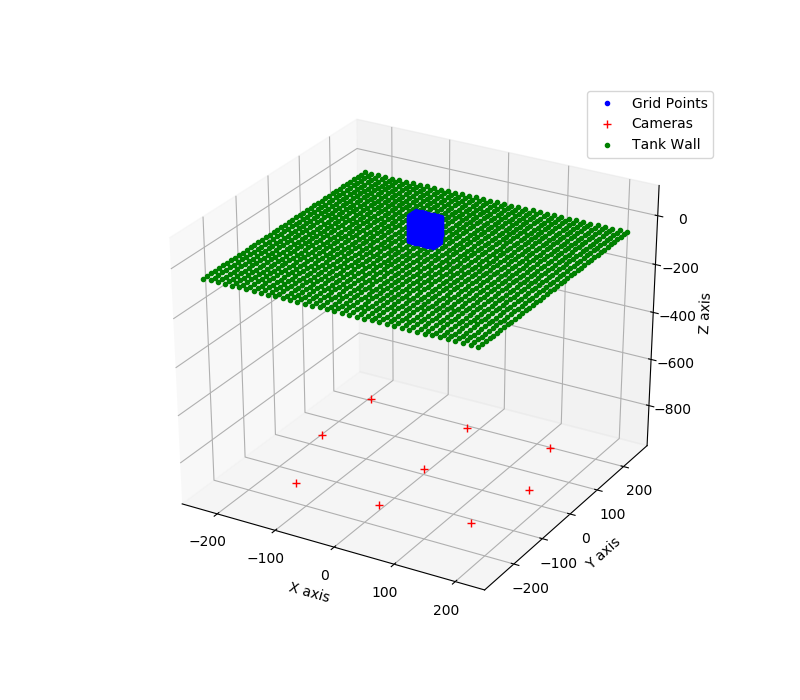

../sample_data/synthetic/calibration_results\results_1403081020.dat

Data saved in <_io.TextIOWrapper name='../sample_data/synthetic/calibration_results\\results_1403081020.dat' mode='w' encoding='cp1252'>


In [5]:
############################################# MAIN LOOP #######################################################


if __name__ == "__main__":
    
    # read config file flag passed from terminal
    '''
    parser = argparse.ArgumentParser()
    parser.add_argument('-c', '--config_file', help='relative path to config file', type=str)
    args = parser.parse_args()
    configPath = args.config_file
    '''
    configPath = 'config_file.cfg'
    
    # parse Config file and setup experimental parameter storage objects
    planeData, cameraData, sceneData, tolerances, calImgs, exptPath, camIDs, bounded = parseConfigFile(configPath)
    
    # call to corner finder to get 2D image plane points
    Umeas = findCorners(planeData, cameraData.ncams, exptPath, imgs = calImgs)
    
    # find pixel scaling using passed in parameters
    pix_phys = getScale(planeData, Umeas)
    
    # find correct camera and plane parameters
    P,camParams,Xworld,planeParams,reprojectionError,errorLog = selfCalibrate(Umeas, planeData, cameraData, 
                                                                              sceneData, tolerances, bounded)
    # plot and save data, check saveCalibData function for format of log file
    print('\nData saved in '+str(saveCalibData(exptPath, camIDs, P, camParams, Xworld, planeParams, sceneData,
                                               cameraData, planeData, errorLog, pix_phys, 'results_')))